In [1]:
import cv2
from matplotlib import pyplot as plt

In [2]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/Shareddrives/OF_image_denoising/FMD/test_mix/raw

Confocal_BPAE_1.ipynb  Confocal_MICE_1.ipynb   TwoPhoton_MICE_1.ipynb
Confocal_BPAE_4.ipynb  Confocal_MICE_1.png     TwoPhoton_MICE_1.png
Confocal_BPAE_B_1.png  Confocal_MICE_2.png     TwoPhoton_MICE_2.png
Confocal_BPAE_B_2.png  Confocal_MICE_3.png     TwoPhoton_MICE_3.png
Confocal_BPAE_B_3.png  Confocal_MICE_4.ipynb   TwoPhoton_MICE_4.png
Confocal_BPAE_B_4.png  Confocal_MICE_4.png     WideField_BPAE_1.ipynb
Confocal_BPAE_G_1.png  TwoPhoton_BPAE_1.ipynb  WideField_BPAE_4.ipynb
Confocal_BPAE_G_2.png  TwoPhoton_BPAE_4.ipynb  WideField_BPAE_B_1.png
Confocal_BPAE_G_3.png  TwoPhoton_BPAE_B_1.png  WideField_BPAE_B_2.png
Confocal_BPAE_G_4.png  TwoPhoton_BPAE_B_2.png  WideField_BPAE_B_3.png
Confocal_BPAE_R_1.png  TwoPhoton_BPAE_B_3.png  WideField_BPAE_B_4.png
Confocal_BPAE_R_2.png  TwoPhoton_BPAE_B_4.png  WideField_BPAE_G_1.png
Confocal_BPAE_R_3.png  TwoPhoton_BPAE_G_1.png  WideField_BPAE_G_2.png
Confocal_BPAE_R_4.png  TwoPhoton_BPAE_G_2.png  WideField_BPAE_G_3.png
Confocal_FISH_1.ipynb  TwoPh

In [4]:
%run /content/drive/Shareddrives/OF_image_denoising/FlowDenoising2D.ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/vicente-gonzalez-ruiz/color_transforms to /tmp/pip-install-bty3l2hw/color-transforms_d0b5e8cc0f2f421da5843443227ecba1
  Running command git clone --filter=blob:none --quiet https://github.com/vicente-gonzalez-ruiz/color_transforms /tmp/pip-install-bty3l2hw/color-transforms_d0b5e8cc0f2f421da5843443227ecba1
  Resolved https://github.com/vicente-gonzalez-ruiz/color_transforms to commit 8dcb71d015db080c1053ea654f528e5ebac32122
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for color_transforms: filename=color_transforms-0.0.1-py3-none-any.whl size=3928 sha256=bebaa27021993c1c3f63c7aa4763ddec4b5aea95029afa4034ad4568da6f9df0
  Stored in directory: /tmp/pip-ephem-wheel-cache-4x8puj8f/wheels/23/f6/51/ae1a3f4c5165067ec91459e12edbb0db134721f90fac426d00
Successfully bu

In [5]:
fn = "/content/drive/Shareddrives/OF_image_denoising/FMD/test_mix/raw/Confocal_FISH_4.png"
noisy = cv2.imread(fn, cv2.IMREAD_UNCHANGED)

In [6]:
fn = "/content/drive/Shareddrives/OF_image_denoising/FMD/test_mix/gt/Confocal_FISH_4.png"
GT = cv2.imread(fn, cv2.IMREAD_UNCHANGED)

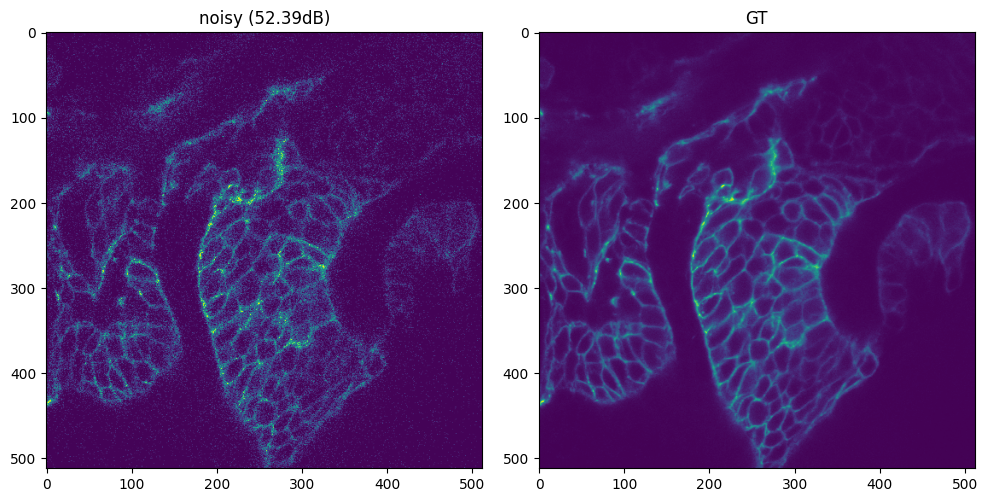

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(normalize(noisy).astype(np.uint8))
axs[0].set_title(f"noisy ({PSNR(noisy, GT):4.2f}dB)")
axs[1].imshow(normalize(GT).astype(np.uint8))
axs[1].set_title("GT")
fig.tight_layout()
plt.show()

## Standard Gaussian Denoising (GD)

In [8]:
# Denoising parameters
N_iters = 1
sigma_GD = 1.5

In [9]:
kernel = gaussian_kernel(sigma_GD)
#kernel = np.array([0.25, 0.5, 0.25])
print(kernel.size, kernel)

13 [8.92210686e-05 1.02819658e-03 7.59740220e-03 3.59943481e-02
 1.09341175e-01 2.12967529e-01 2.65964257e-01 2.12967529e-01
 1.09341175e-01 3.59943481e-02 7.59740220e-03 1.02819658e-03
 8.92210686e-05]


In [10]:
denoised = noisy.copy()
for i in range(N_iters):
    denoised = gray_gaussian_filtering(denoised, kernel)
    #plt.imshow(RGB_normalize(denoised).astype(np.uint8))
    #plt.title(f"iter {i}")
    #plt.show()
    print(PSNR(denoised, GT))

72.03223672306905


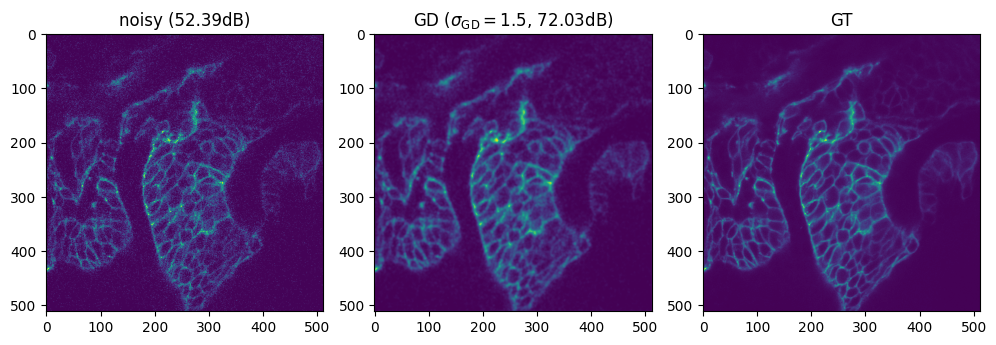

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].imshow(normalize(noisy).astype(np.uint8))
axs[0].set_title(f"noisy ({PSNR(noisy, GT):4.2f}dB)")
axs[1].imshow(normalize(denoised).astype(np.uint8))
axs[1].set_title("GD " + "($\sigma_\mathrm{GD}=" + f"{sigma_GD}$, " + f"{PSNR(denoised, GT):4.2f}dB)")
axs[2].imshow(normalize(GT).astype(np.uint8))
axs[2].set_title("GT")
fig.tight_layout()
plt.show()

In [12]:
GD = denoised.copy()

## OF-driven Gaussian Denoising (OF-GD)

In [13]:
N_iters = 4     # Número de iteraciones de filtrado. Cuanto más alto, mayor el emborronamiento
l = 3           # Número de niveles usado en la pirámide gaussiana generada por Farneback. A mayor número, mayores áreas de búsqueda de los vectores OF, pero mayor probabilidad de sensibilidad al ruido.
w = 5           # Tamaño de la ventana usada en Farneback para calcular un vector OF. A mayor valor, más suavidad en los campos OF.
sigma_OF = 0.75  # Controla la variablidad de los campos OF. Cuando mayor es este valor, más suaves son los campos (mayor resistencia al ruido).

In [14]:
denoised = noisy.copy()
print(f"N_iters={N_iters}")
for i in range(N_iters):
    denoised = gray_OF_gaussian_filtering(denoised, kernel, l, w, sigma_OF)
    #plt.imshow(normalize(denoised).astype(np.uint8))
    #plt.title(f"iter {i}")
    #plt.show()
    print(f"\niter={i} PSNR={PSNR(denoised, GT)}")

N_iters=4
v3
0 0.12925047 0.17965221 0.19950508 0.22672066 0.30980375 0.4308093 0.04548181 0.37213615 0.17656933 0.36273006 0.20085648 0.20100708 0.35549414 1 0.22314215 0.36498433 0.17049563 0.23830205 0.18694402 0.41857466 0.030142397 0.46517032 0.3204936 0.17792377 0.48430923 0.25245544 0.36644456 2 0.17885494 0.18461376 0.1446547 0.07422778 0.14138822 0.33998075 0.036048036 0.43289408 0.16566199 0.20923738 0.1508798 0.11161324 0.18374908 3 0.20415115 0.3499637 0.2339042 0.39127532 0.20427163 0.38900048 0.05435693 0.5279799 0.27014625 0.2607083 0.42595124 0.17601147 0.18396764 4 0.47800153 0.2219834 0.29063302 0.38152227 0.33094493 0.58887106 0.06983906 0.55144733 0.2633187 0.47661525 0.15488766 0.62775433 0.4871429 5 0.21187134 0.20085883 0.4709249 0.21572553 0.20754571 0.7547061 0.0465039 0.7925307 0.41078714 0.38573328 0.52547646 0.23882747 0.4571385 6 0.30911276 0.19878079 0.17178778 0.30755803 0.17426157 0.52031 0.03920887 0.43886906 0.7454958 0.22450255 0.17001088 0.24273694 0

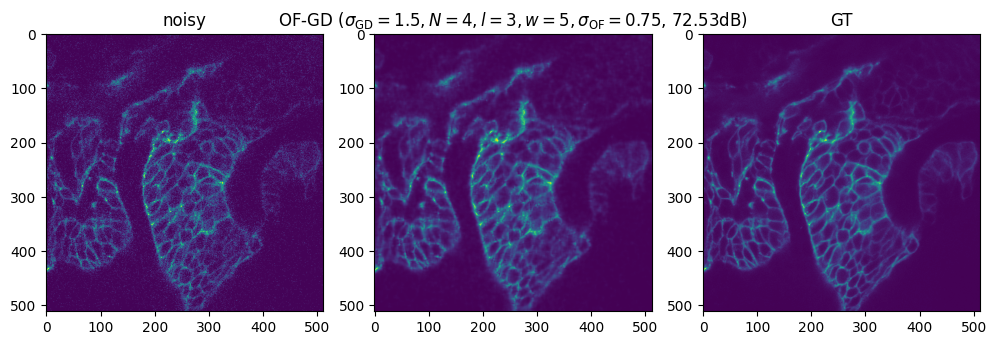

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].imshow(normalize(noisy).astype(np.uint8))
axs[0].set_title("noisy")
axs[1].imshow(normalize(denoised).astype(np.uint8))
axs[1].set_title("OF-GD ($\sigma_\mathrm{GD}=" + f"{sigma_GD}, N={N_iters}, l={l}, w={w}, $" + "$\sigma_\mathrm{OF}=$" + f"${sigma_OF}$, " + f"{PSNR(denoised, GT):4.2f}dB)")
axs[2].imshow(normalize(GT).astype(np.uint8))
axs[2].set_title("GT")
fig.tight_layout()
plt.show()

In [16]:
OF_GD = denoised.copy()

## OF-driven Random Denoising (OF-RD)

In [17]:
N_iters = 50
sigma_RD = 1.5
l = 2
w = 19
sigma_OF = 0.90

In [18]:
denoised = denoise(warp_B_to_A, noisy, iters=N_iters, sigma_RD=sigma_RD, l=l, w=w, sigma_OF=sigma_OF)

50 0.0 1.5 2 19 0.9
0 6 6
0.4638491 2 19 0.9 1 6 6
0.47186312 2 19 0.9 2 7 6
0.45296085 2 19 0.9 3 6 7
0.46552143 2 19 0.9 4 7 7
0.44641635 2 19 0.9 5 6 6
0.44922078 2 19 0.9 6 6 7
0.43031874 2 19 0.9 7 7 6
0.43405136 2 19 0.9 8 6 6
0.4209838 2 19 0.9 9 7 6
0.42195353 2 19 0.9 10 6 7
0.42277056 2 19 0.9 11 6 7
0.42269984 2 19 0.9 12 6 6
0.4125933 2 19 0.9 13 7 6
0.41809833 2 19 0.9 14 7 7
0.4176845 2 19 0.9 15 7 6
0.40990418 2 19 0.9 16 6 6
0.42058566 2 19 0.9 17 6 6
0.41109228 2 19 0.9 18 6 7
0.4118295 2 19 0.9 19 6 7
0.40775067 2 19 0.9 20 7 6
0.40996632 2 19 0.9 21 7 7
0.4047212 2 19 0.9 22 7 7
0.4068643 2 19 0.9 23 6 7
0.40269187 2 19 0.9 24 7 7
0.40066516 2 19 0.9 25 6 7
0.4042356 2 19 0.9 26 6 7
0.4043402 2 19 0.9 27 6 6
0.39881265 2 19 0.9 28 6 6
0.40727392 2 19 0.9 29 7 6
0.39580193 2 19 0.9 30 7 6
0.40147895 2 19 0.9 31 7 6
0.4015756 2 19 0.9 32 6 6
0.40091676 2 19 0.9 33 6 6
0.3879946 2 19 0.9 34 6 6
0.39891434 2 19 0.9 35 6 7
0.39096323 2 19 0.9 36 6 6
0.39684448 2 19 0.9 37

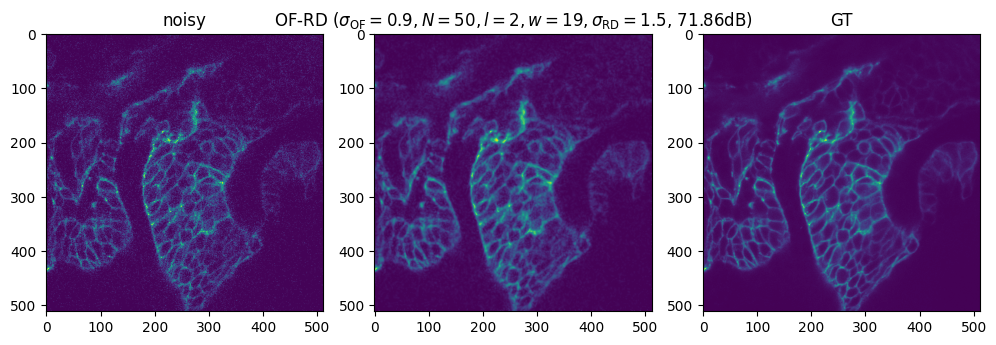

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].imshow(normalize(noisy).astype(np.uint8))
axs[0].set_title("noisy")
axs[1].imshow(normalize(denoised).astype(np.uint8))
axs[1].set_title("OF-RD " + "($\sigma_\mathrm{OF}=$" + f"${sigma_OF}, N={N_iters}, l={l}, w={w}, $" + "$\sigma_\mathrm{RD}=$" + fr"${sigma_RD}$, " + f"{PSNR(denoised, GT):4.2f}dB)")
axs[2].imshow(normalize(GT).astype(np.uint8))
axs[2].set_title("GT")
fig.tight_layout()
plt.show()

In [20]:
OF_RD = denoised.copy()

## Final comparison

In [21]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs[0, 0].imshow(noisy.astype(np.uint8))
axs[0, 0].set_title(f"noisy ({PSNR(noisy, GT):4.2f}dB)")
axs[0, 1].imshow(GT.astype(np.uint8))
axs[0, 1].set_title("GT")
axs[1, 0].imshow(GD.astype(np.uint8))
axs[1, 0].set_title(f"GD ({PSNR(GD, GT):4.2f}dB)")
axs[1, 1].imshow(GT.astype(np.uint8))
axs[1, 1].set_title("GT")
axs[2, 0].imshow(OF_GD.astype(np.uint8))
axs[2, 0].set_title(f"OF-GD ({PSNR(OF_GD, GT):4.2f}dB)")
axs[2, 1].imshow(GT.astype(np.uint8))
axs[2, 1].set_title("GT")
axs[3, 0].imshow(OF_RD.astype(np.uint8))
axs[3, 0].set_title(f"OF-RD ({PSNR(OF_RD, GT):4.2f}dB)")
axs[3, 1].imshow(GT.astype(np.uint8))
axs[3, 1].set_title("GT")
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.